In this final notebook, we use the `etm` package to fit multistate models to the state transitions derivable from the EMR visit data.

We do not used matched cohorts for the multistate model, since it needs to properly estimate competing risks between acquiring CDI and being discharged, and a 1:1 matched dataset would make this look like a much closer competition than it actually is. (In reality, most patients are discharged without ever becoming CDI positive during their visit; 1:1 matched cohorts make this look like a 50% split to a multistate model.)

In [37]:
library(lattice)
library(etm)
load("data/analysis_3_matchit-los-m-df.RData")
options(jupyter.plot_mimetypes = "image/svg+xml") 
#load(file="data/analysis_3_etm.RData") # load data from a previous run

We don't fit this model to either case definition (i) or (v), because those include visits where the only information about CDI is a visit diagnosis code that doesn't indicate what the presumptive time-to-infection was. Therefore, we skip the 1a section you saw in previous notebooks and start with 1b.

## 1b. `cdtox_eia_positive=TRUE`

In [ ]:
los.df.cdtox_eia <- los.m.df[los.m.df$case_def == 'cdtox_eia' & los.m.df$cdi_status %in% c("all cases", "all controls"),]
los.df.cdtox_eia$cdi_status <- factor(as.character(los.df.cdtox_eia$cdi_status))

One **notable** alteration to the dataset before proceeding further. Because sometimes the final CDI lab result occurs after discharge, we have to ensure it is clipped to before the `length_of_stay` value, and we also have to make sure the lab result doesn't arrive at time 0.

In both these cases, we make sure it's at least 0.5 days (12 hours) after admit and no more than 0.5 days before discharge. The minimum `length_of_stay` is clipped to 1 day, because tiny `length_of_stay` values disproportionately affect the model.

Finally, we round off all time values to 0.1 day (2.4 hours) precision as it simplifies later calculations, which have to loop repeatedly over all possible time values. (With fewer possible time values, the time of computation decreases dramatically.)

In [39]:
los.df.cdtox_eia$length_of_stay <- round(pmax(los.df.cdtox_eia$length_of_stay, 1), 1)
los.df.cdtox_eia$cdtox_positive_after <- round(pmax(0.5,
                                                    pmin(los.df.cdtox_eia$length_of_stay - 0.5,
                                                         los.df.cdtox_eia$cdtox_positive_after)), 1)
summary(los.df.cdtox_eia$length_of_stay)
summary(los.df.cdtox_eia$cdtox_positive_after)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
   1.000    1.600    2.900    5.331    5.300 1341.000 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
   0.50    2.10    6.05   10.55   13.45  129.90   73643 

In [ ]:
tr.df.cdtox_eia <- los.df.cdtox_eia
tr.df.cdtox_eia$id <- 1:nrow(tr.df.cdtox_eia)

tr.df.cdtox_eia <- tmerge(tr.df.cdtox_eia, tr.df.cdtox_eia, id=id, tstop=length_of_stay, 
                             disch=event(length_of_stay))
tr.df.cdtox_eia <- tmerge(tr.df.cdtox_eia, tr.df.cdtox_eia, id=id, 
                             cdi_status.tdc=tdc(cdtox_positive_after))

tr.df.cdtox_eia$cdi_status.bool <- tr.df.cdtox_eia$cdi_status == 'all cases'
tr.df.cdtox_eia$length_of_stay <- NULL
tr.df.cdtox_eia$case_def <- NULL
tr.df.cdtox_eia$cdtox_positive_after <- NULL

tr.df.cdtox_eia$from <- ifelse(tr.df.cdtox_eia$cdi_status.tdc, "1", "0")
tr.df.cdtox_eia$to <- ifelse(tr.df.cdtox_eia$cdi_status.tdc, "2", 
                                ifelse(tr.df.cdtox_eia$disch, "2", "1"))
tr.df.cdtox_eia$time <- tr.df.cdtox_eia$tstop

tr.df.cdtox_eia$tstart <- NULL
tr.df.cdtox_eia$tstop <- NULL
tr.df.cdtox_eia$cdi_status <- NULL

In [41]:
tr.mat <- matrix(FALSE, 3, 3)
rownames(tr.mat) <- colnames(tr.mat) <- 0:2
tr.mat[1, 2:3] <- TRUE
tr.mat[2, 3] <- TRUE
tr.mat

,0,1,2
0,FALSE,TRUE,TRUE
1,FALSE,FALSE,TRUE
2,FALSE,FALSE,FALSE


There are some tremendous outliers in this dataset; in particular, some visits go as long as 1341 days. To keep the model focused on regions with sufficient data, we forgo calculation of the model past the 99th percentile of recorded time events.

In [42]:
summary(tr.df.cdtox_eia$time)
quantile(tr.df.cdtox_eia$time, probs=c(0.99))

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
   0.500    1.600    2.900    5.354    5.300 1341.000 

99% 
38.9

In [43]:
tr.prob.cdtox_eia <- etm(tr.df.cdtox_eia, 0:2, tr.mat, NULL, 0, t=quantile(tr.df.cdtox_eia$time, probs=c(0.99)))

We can plot the Aalen-Johansen estimators that were fit to all the allowed state transitions.

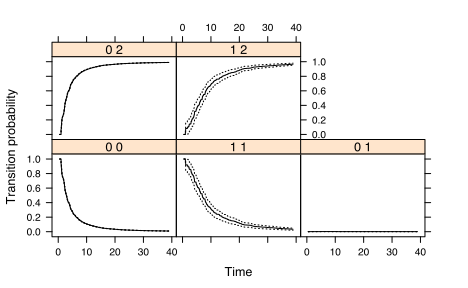

In [44]:
xyplot(tr.prob.cdtox_eia)

In [45]:
ptm <- proc.time()
cLOS.cdtox_eia <- etm::clos(tr.prob.cdtox_eia)
proc.time() - ptm

   user  system elapsed 
  0.291   0.001   0.293 

The following is the default plot for `cLOS` objects, which isn't very good.

The expected change in length of stay is:
2.995 


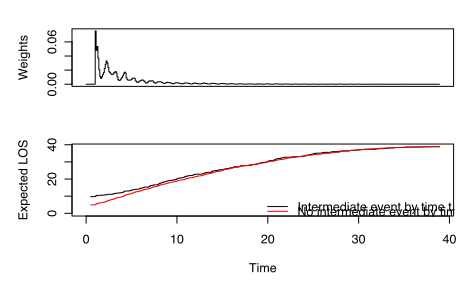

In [46]:
print(cLOS.cdtox_eia)
plot(cLOS.cdtox_eia)

The following performs bootstrap resamples of the dataset *by patient ID* and recalculates `cLOS`, which can then be used to generate confidence intervals.

Note that this is an optimized and parallelized version of the [example](https://cran.r-project.org/web/packages/etm/etm.pdf) seen for `?clos`. The original uses lots of full data frame scans and for loops, which can be eliminated by preindexing and carefully using subsetting with `sapply`.

In [47]:
require(parallel)

boot.clos <- function(data, state.names, tra, cens.name, s = 0, t = "last", nboot = 10, mc.cores = 10) {    
    each.boot <- function(i, data, state.names, tra, cens.name, s, t, id.index) {
        index <- sample(unique(data$id), replace = TRUE)
        inds <- unname(unlist(id.index[as.character(index)]))
        lengths <- sapply(id.index[as.character(index)], length)
        new.id <- unlist(sapply(seq_along(index), function(i) { rep(i, lengths[[i]]) }))
        
        dboot <- cbind(data[inds, ], new.id)
        dboot[, which(names(dboot) == "id")]
        dboot$id <- dboot$new.id
        tr.prob <- etm(dboot, state.names, tra, cens.name, s, t = t, cova = FALSE)
        etm::clos(tr.prob)
    }
    
    ids <- unique(data$id)
    id.index <- lapply(ids, function(i) { which(data$id == i) })
    names(id.index) <- ids
    
    MoreArgs <- list(data=data, state.names=state.names, tra=tra, cens.name=cens.name, s=s, t=t, id.index=id.index)
    res <- mcmapply(i=1:nboot, FUN=each.boot, MoreArgs=MoreArgs, SIMPLIFY=FALSE, mc.cores=mc.cores)
    res
}

**NOTE**: 1000 bootstrap runs of the cLOS procedure to generate confidence intervals takes about 3 minutes across 10 CPU cores.

In [48]:
ptm <- proc.time()
cLOS.boot.cdtox_eia <- boot.clos(tr.df.cdtox_eia, 0:2, tr.mat, NULL, 0, quantile(tr.df.cdtox_eia$time, probs=c(0.99)), nboot=1000)
proc.time() - ptm

    user   system  elapsed 
1329.532   58.286  187.019 

`plot.cLOS.boot` plots the expected additional LOS for each group with 95% CI calculated from the bootstrapped reruns. Note that it uses an empirical bootstrap, not a bootstrap percentile method, for reasons [explained here](https://ocw.mit.edu/courses/mathematics/18-05-introduction-to-probability-and-statistics-spring-2014/readings/MIT18_05S14_Reading24.pdf).

The standard errors are also calculated in case we want to use the Normal bootstrap CI, but [that requires an assumption of normality](https://www.unc.edu/courses/2007spring/biol/145/001/docs/lectures/Sep17.html), which is likely unjustified here.

In [49]:
summary.cLOS.boot <- function(cLOS.orig, cLOS.boot) {
    e.phi <- unlist(sapply(cLOS.boot, function(run) { run$e.phi }))
    e.phi.mean <- mean(e.phi)
    e.phi.se <- sd(e.phi)
    e.phi.delta <- e.phi - cLOS.orig$e.phi
    
    list(
        e.phi = cLOS.orig$e.phi,
        boot.mean = e.phi.mean,
        se = e.phi.se,
        ci95 = c(cLOS.orig$e.phi + quantile(e.phi.delta, probs=0.025), 
                 cLOS.orig$e.phi + quantile(e.phi.delta, probs=0.975))
    )
}

require(ggplot2)
require(cowplot)

plot.CLOS.boot.pal <- c("red3", "gray20")

plot.cLOS.boot <- function(cLOS.orig, cLOS.boot, xlab = "Time post-admit (days)", ylab = "Expected remaining LOS (days)", 
                           main = "", grp.labels=c("(+) diagnosis by time t", "No diagnosis by time t"),
                           CI.type = "basic") {
    times <- cLOS.orig$time
    boot.phi.case <- sapply(times, function(t) { 
        sapply(cLOS.boot, function(run) { 
            i <- match(t, run$time)
            ifelse(is.na(i), NA, run$phi.case[i])
        })
    })
    boot.phi.control <- sapply(times, function(t) { 
        sapply(cLOS.boot, function(run) { 
            i <- match(t, run$time)
            ifelse(is.na(i), NA, run$phi.control[i])
        })
    })
    boot.phi <- cbind(boot.phi.case, boot.phi.control)
    
    dat <- data.frame(
        time = c(times, times),
        phi = c(cLOS.orig$phi.case, cLOS.orig$phi.control),
        phi.se = apply(boot.phi, MARGIN=2, FUN=sd, na.rm=TRUE),
        group = c(rep("case", length(times)), rep("control", length(times)))
    )
    boot.phi.delta <- sweep(boot.phi, 2, dat$phi)
    dat$phi <- dat$phi - dat$time
    
    if (CI.type == "norm") {
        dat$phi.up <- dat$phi + 2 * dat$phi.se
        dat$phi.low <- dat$phi - 2 * dat$phi.se
    } else {
        dat$phi.up <- dat$phi + apply(boot.phi.delta, MARGIN=2, FUN=quantile, probs=0.975, na.rm=TRUE)
        dat$phi.low <- dat$phi + apply(boot.phi.delta, MARGIN=2, FUN=quantile, probs=0.025, na.rm=TRUE)
    }
    
    ggplot(dat, aes(x = time, y = phi, group = group)) +
        xlab(xlab) + ylab(ylab) + ggtitle(main) + expand_limits(y = 0) +
        geom_line(aes(col = group, linetype = group),) +
        geom_ribbon(aes(ymin=phi.low, ymax=phi.up, fill=group), alpha=0.3) +
        scale_linetype_discrete(name="group", labels=grp.labels) +
        scale_fill_manual(values=plot.CLOS.boot.pal, name="group", labels=grp.labels) +
        scale_color_manual(values=plot.CLOS.boot.pal, name="group", labels=grp.labels) +
        coord_cartesian(xlim=c(0, max(times) * 0.8)) +
        theme(legend.position=c(0.2, 0.2), legend.title=element_blank())
}

In [50]:
summary.cLOS.boot(cLOS.cdtox_eia, cLOS.boot.cdtox_eia)

$e.phi
[1] 2.994686

$boot.mean
[1] 3.034145

$se
[1] 0.5353327

$ci95
    2.5%    97.5% 
2.044357 4.046792

Plots the expected *remaining* LOS at each timepoint given having acquired CDI by that timepoint, with the 95% CI created during the above bootstrap.

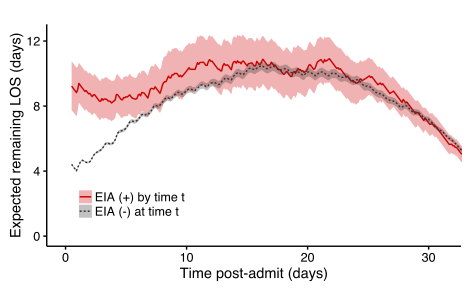

In [51]:
options(repr.plot.width=6.5, repr.plot.height=4)
gg <- plot.cLOS.boot(cLOS.cdtox_eia, cLOS.boot.cdtox_eia, grp.labels=c("EIA (+) by time t", "EIA (-) at time t"))
save_plot("data/analysis_3_etm-cdtox_eia.pdf", gg, base_height=3.5, base_aspect_ratio=1.8)
gg

## 1c. `cdtox_pcr_positive=TRUE`

**Again**, because sometimes the final CDI lab result occurs after discharge, we have to ensure it is clipped to before the `length_of_stay` value, and we also have to make sure the lab result doesn't arrive at time 0.

In both these cases, we make sure it's at least 0.5 days (12 hours) after admit and no more than 0.5 days before discharge. The minimum `length_of_stay` is clipped to 1 day, because tiny `length_of_stay` values disproportionately affect the model.

Finally, we round off all time values to 0.1 day (2.4 hours) precision as it simplifies further calculations, which generally have to loop repeatedly over all possible time values.

In [52]:
los.df.cdtox_pcr <- los.m.df[los.m.df$case_def == 'cdtox_pcr' & los.m.df$cdi_status %in% c("all cases", "all controls"),]
los.df.cdtox_pcr$cdi_status <- factor(as.character(los.df.cdtox_pcr$cdi_status))

los.df.cdtox_pcr$length_of_stay <- round(pmax(los.df.cdtox_pcr$length_of_stay, 1), 1)
los.df.cdtox_pcr$cdtox_positive_after <- round(pmax(0.5,
                                              pmin(los.df.cdtox_pcr$length_of_stay - 0.5,
                                                   los.df.cdtox_pcr$cdtox_positive_after)), 1)
summary(los.df.cdtox_pcr$length_of_stay)
summary(los.df.cdtox_pcr$cdtox_positive_after)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   2.000   3.100   5.612   5.800 854.200 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
   0.50    1.30    4.70    9.31    9.10  250.30   97351 

In [ ]:
tr.df.cdtox_pcr <- los.df.cdtox_pcr
tr.df.cdtox_pcr$id <- 1:nrow(tr.df.cdtox_pcr)

tr.df.cdtox_pcr <- tmerge(tr.df.cdtox_pcr, tr.df.cdtox_pcr, id=id, tstop=length_of_stay, 
                             disch=event(length_of_stay))
tr.df.cdtox_pcr <- tmerge(tr.df.cdtox_pcr, tr.df.cdtox_pcr, id=id, 
                             cdi_status.tdc=tdc(cdtox_positive_after))

tr.df.cdtox_pcr$cdi_status.bool <- tr.df.cdtox_pcr$cdi_status == 'all cases'
tr.df.cdtox_pcr$length_of_stay <- NULL
tr.df.cdtox_pcr$case_def <- NULL
tr.df.cdtox_pcr$cdtox_positive_after <- NULL

tr.df.cdtox_pcr$from <- ifelse(tr.df.cdtox_pcr$cdi_status.tdc, "1", "0")
tr.df.cdtox_pcr$to <- ifelse(tr.df.cdtox_pcr$cdi_status.tdc, "2", 
                                ifelse(tr.df.cdtox_pcr$disch, "2", "1"))
tr.df.cdtox_pcr$time <- tr.df.cdtox_pcr$tstop

tr.df.cdtox_pcr$tstart <- NULL
tr.df.cdtox_pcr$tstop <- NULL
tr.df.cdtox_pcr$cdi_status <- NULL

In [54]:
summary(tr.df.cdtox_pcr$time)
quantile(tr.df.cdtox_pcr$time, probs=c(0.99))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.500   2.000   3.100   5.636   5.800 854.200 

99% 
41.9

Again, to keep the model focused on regions with sufficient data, we forgo calculation of the model past the 99th percentile of recorded time events.

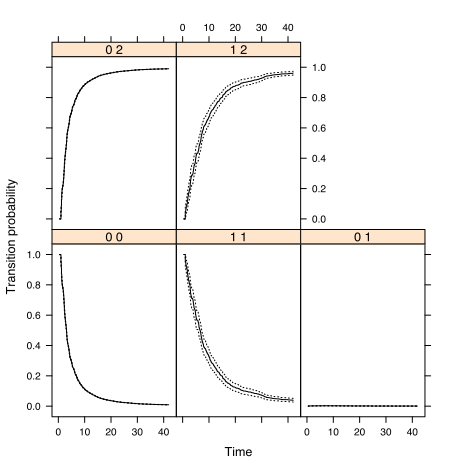

In [55]:
tr.prob.cdtox_pcr <- etm(tr.df.cdtox_pcr, 0:2, tr.mat, NULL, 0, t=quantile(tr.df.cdtox_pcr$time, probs=c(0.99)))
options(repr.plot.width=6.5, repr.plot.height=6.5)
xyplot(tr.prob.cdtox_pcr)

In [56]:
ptm <- proc.time()
cLOS.cdtox_pcr <- etm::clos(tr.prob.cdtox_pcr)
proc.time() - ptm

   user  system elapsed 
  0.337   0.001   0.338 

The expected change in length of stay is:
3.508 


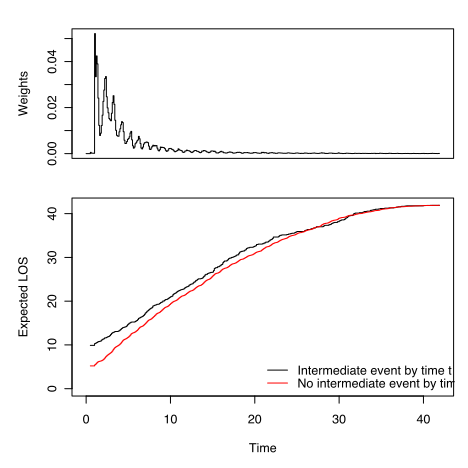

In [57]:
print(cLOS.cdtox_pcr)
plot(cLOS.cdtox_pcr)

**NOTE**: 1000 bootstrap runs of the cLOS procedure to generate confidence intervals takes about 3 minutes across 10 CPU cores.

In [58]:
ptm <- proc.time()
cLOS.boot.cdtox_pcr <- boot.clos(tr.df.cdtox_pcr, 0:2, tr.mat, NULL, 0, quantile(tr.df.cdtox_pcr$time, probs=c(0.99)), nboot=100)
proc.time() - ptm

   user  system elapsed 
334.624  27.752  79.165 

In [59]:
summary.cLOS.boot(cLOS.cdtox_pcr, cLOS.boot.cdtox_pcr)

$e.phi
[1] 3.508098

$boot.mean
[1] 3.568473

$se
[1] 0.4783563

$ci95
    2.5%    97.5% 
2.748807 4.475254

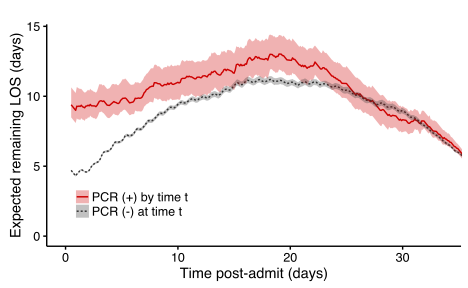

In [60]:
options(repr.plot.width=6.5, repr.plot.height=4)
gg <- plot.cLOS.boot(cLOS.cdtox_pcr, cLOS.boot.cdtox_pcr, grp.labels=c("PCR (+) by time t", "PCR (-) at time t"))
save_plot("data/analysis_3_etm-cdtox_pcr.pdf", gg, base_height=3.5, base_aspect_ratio=1.8)
gg

## 1d. Either 1b OR 1c

In [ ]:
los.df.cdtox_all <- los.m.df[los.m.df$case_def == 'cdtox_all' & los.m.df$cdi_status %in% c("all cases", "all controls"),]
los.df.cdtox_all$cdi_status <- factor(as.character(los.df.cdtox_all$cdi_status))

**Again**, because sometimes the final CDI lab result occurs after discharge, we have to ensure it is clipped to before the `length_of_stay` value, and we also have to make sure the lab result doesn't arrive at time 0.

In both these cases, we make sure it's at least 0.5 days (12 hours) after admit and no more than 0.5 days before discharge. The minimum `length_of_stay` is clipped to 1 day, because tiny `length_of_stay` values disproportionately affect the model.

Finally, we round off all time values to 0.1 day (2.4 hours) precision as it simplifies further calculations, which generally have to loop repeatedly over all possible time values.

In [62]:
los.df.cdtox_all$length_of_stay <- round(pmax(los.df.cdtox_all$length_of_stay, 1), 1)
los.df.cdtox_all$cdtox_positive_after <- round(pmax(0.5,
                                                    pmin(los.df.cdtox_all$length_of_stay - 0.5,
                                                         los.df.cdtox_all$cdtox_positive_after)), 1)
summary(los.df.cdtox_all$length_of_stay)
summary(los.df.cdtox_all$cdtox_positive_after)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1.00    1.80    3.00    5.49    5.50 1341.00 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
   0.50    1.70    5.20    9.58   10.42  250.30  170994 

First, some data arrangement to create the one-row-per-transition data frame needed by the [etm package](https://cran.r-project.org/web/packages/etm/).

In [ ]:
tr.df.cdtox_all <- los.df.cdtox_all
tr.df.cdtox_all$id <- 1:nrow(tr.df.cdtox_all)

tr.df.cdtox_all <- tmerge(tr.df.cdtox_all, tr.df.cdtox_all, id=id, tstop=length_of_stay, 
                          disch=event(length_of_stay))
tr.df.cdtox_all <- tmerge(tr.df.cdtox_all, tr.df.cdtox_all, id=id, 
                          cdi_status.tdc=tdc(cdtox_positive_after))

tr.df.cdtox_all$cdi_status.bool <- tr.df.cdtox_all$cdi_status == 'all cases'
tr.df.cdtox_all$length_of_stay <- NULL
tr.df.cdtox_all$case_def <- NULL
tr.df.cdtox_all$cdtox_positive_after <- NULL

tr.df.cdtox_all$from <- ifelse(tr.df.cdtox_all$cdi_status.tdc, "1", "0")
tr.df.cdtox_all$to <- ifelse(tr.df.cdtox_all$cdi_status.tdc, "2", 
                             ifelse(tr.df.cdtox_all$disch, "2", "1"))
tr.df.cdtox_all$time <- tr.df.cdtox_all$tstop

tr.df.cdtox_all$tstart <- NULL
tr.df.cdtox_all$tstop <- NULL
tr.df.cdtox_all$cdi_status <- NULL

In [64]:
summary(tr.df.cdtox_all$time)
quantile(tr.df.cdtox_all$time, probs=c(0.99))

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
   0.500    1.800    3.000    5.512    5.600 1341.000 

99% 
40.9

Again, to keep the model focused on regions with sufficient data, we forgo calculation of the model past the 99th percentile of recorded time events.

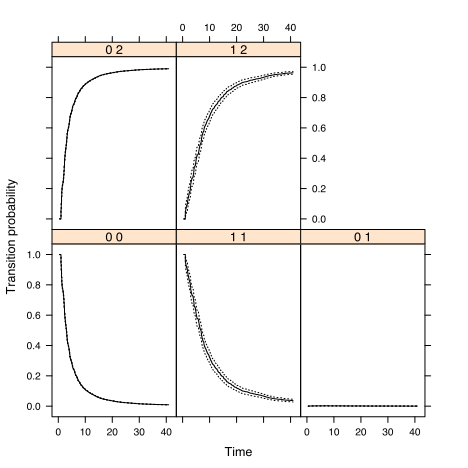

In [65]:
tr.prob.cdtox_all <- etm(tr.df.cdtox_all, 0:2, tr.mat, NULL, 0, t=quantile(tr.df.cdtox_all$time, probs=c(0.99)))
options(repr.plot.width=6.5, repr.plot.height=6.5)
xyplot(tr.prob.cdtox_all)

In [66]:
ptm <- proc.time()
cLOS.cdtox_all <- etm::clos(tr.prob.cdtox_all)
proc.time() - ptm

   user  system elapsed 
  0.311   0.000   0.312 

The expected change in length of stay is:
3.299 


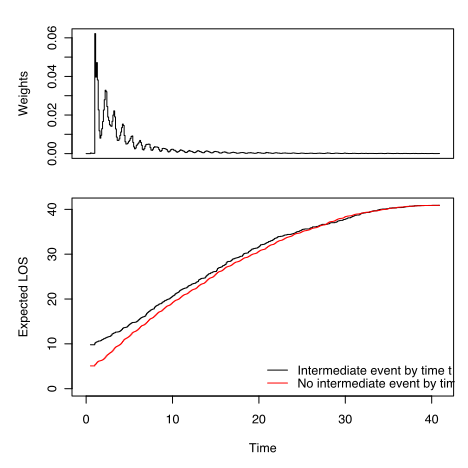

In [67]:
print(cLOS.cdtox_all)
plot(cLOS.cdtox_all)

**NOTE**: 1000 bootstrap runs of the cLOS procedure to generate confidence intervals takes about 3 minutes across 10 CPU cores.

In [68]:
ptm <- proc.time()
cLOS.boot.cdtox_all <- boot.clos(tr.df.cdtox_all, 0:2, tr.mat, NULL, 0, quantile(tr.df.cdtox_all$time, probs=c(0.99)), nboot=100)
proc.time() - ptm

   user  system elapsed 
323.549  49.946 203.154 

In [69]:
summary.cLOS.boot(cLOS.cdtox_all, cLOS.boot.cdtox_all)

$e.phi
[1] 3.298613

$boot.mean
[1] 3.282581

$se
[1] 0.3141837

$ci95
    2.5%    97.5% 
2.553244 3.951882

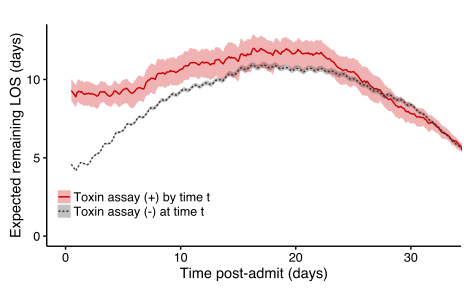

In [70]:
options(repr.plot.width=6.5, repr.plot.height=4)
gg <- plot.cLOS.boot(cLOS.cdtox_all, cLOS.boot.cdtox_all, grp.labels=c("Toxin assay (+) by time t", "Toxin assay (-) at time t"))
save_plot("data/analysis_3_etm-cdtox_all.pdf", gg, base_height=3.5, base_aspect_ratio=1.8)
gg

# Save `etm` and `cLOS` output

In [71]:
ls()

[1] "boot.clos"           "cLOS.boot.cdtox_all" "cLOS.boot.cdtox_eia"
 [4] "cLOS.boot.cdtox_pcr" "cLOS.cdtox_all"      "cLOS.cdtox_eia"     
 [7] "cLOS.cdtox_pcr"      "gg"                  "los.df.cdtox_all"   
[10] "los.df.cdtox_eia"    "los.df.cdtox_pcr"    "los.m.df"           
[13] "plot.cLOS.boot"      "plot.CLOS.boot.pal"  "ptm"                
[16] "summary.cLOS.boot"   "tr.df.cdtox_all"     "tr.df.cdtox_eia"    
[19] "tr.df.cdtox_pcr"     "tr.mat"              "tr.prob.cdtox_all"  
[22] "tr.prob.cdtox_eia"   "tr.prob.cdtox_pcr"

In [72]:
save(cLOS.boot.cdtox_all, cLOS.boot.cdtox_eia, cLOS.boot.cdtox_pcr,
     cLOS.cdtox_all, cLOS.cdtox_eia, cLOS.cdtox_pcr,
     file="data/analysis_3_etm.RData")